In [1]:
%pylab inline
import torch
from torch.nn.parameter import Parameter

Populating the interactive namespace from numpy and matplotlib


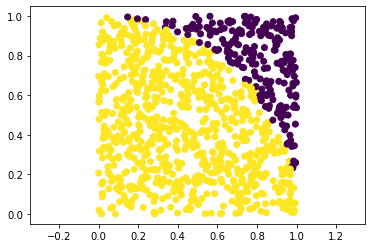

In [2]:
x = torch.rand([1000, 2])
x_in_circle = (x**2).sum(1) < 1

def accuracy(pred_y):
    return (pred_y == x_in_circle).float().mean()

def show(y):
    scatter(*x.numpy().T, c=y.numpy())
    axis('equal')

def loss(p_y):
    return -(x_in_circle.float()*(p_y+1e-10).log() + (1 - x_in_circle.float())*(1-p_y+1e-10).log()).mean()

class Linear(torch.nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.w = Parameter(torch.ones(input_dim))
        self.b = Parameter(-torch.ones(1))
        
    def forward(self, x):
        return (x*self.w[None,:]).sum(1) + self.b
    
class LinearClassifier(torch.nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.linear = Linear(input_dim)
        
    def forward(self, x):
        logit = self.linear(x)
        return 1 / (1 + (-logit).exp())
    
show(x_in_circle)

In [3]:
import torch.utils.tensorboard as tb
%load_ext tensorboard
import tempfile
log_dir = tempfile.mkdtemp()
%tensorboard --logdir {log_dir} --reload_interval 1

C:\Users\sbbid\anaconda3\lib\site-packages\setuptools\distutils_patch.py:25: UserWarning: Distutils was imported before Setuptools. This usage is discouraged and may exhibit undesirable behaviors or errors. Please use Setuptools' objects directly or at least import Setuptools first.
  warnings.warn(


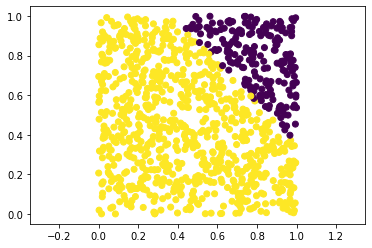

In [4]:
# Set up logging
logger = tb.SummaryWriter(log_dir + '/linear', flush_secs=1)

# Set up model
classifier = LinearClassifier(2)

for iteration in range(5000):
    # Predict the labels and probabilities
    p_y = classifier(x)
    pred_y = p_y > 0.5
    
    # Compute the loss
    l = loss(p_y)
    
    # Logging
    logger.add_scalar('loss', l, global_step=iteration)
    logger.add_scalar('accuracy', accuracy(pred_y), global_step=iteration)
    if iteration % 10 == 0:
        fig = figure()
        show(pred_y)
        logger.add_figure('pred_y', fig, global_step=iteration)
        del fig
        
    # Compute the gradient
    l.backward()

    # Update the weights and bias using gradient descent
    for p in classifier.parameters():
        p.data[:] -= 0.5 * p.grad
        p.grad.zero_()
    
show(pred_y)